<a href="https://colab.research.google.com/github/nanopiero/fusion/blob/master/cible_cmls_spatialises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atelier 4 : Régression multimodale avec un Visual Transformer


In [1]:
# Imports des bibliothèques utiles
# pour l'IA
import torch
# pour les maths
import numpy as np
# pour afficher des images et des courbes
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/nanopiero/PREAC.git

Cloning into 'PREAC'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 124 (delta 65), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (124/124), 7.19 MiB | 5.97 MiB/s, done.
Resolving deltas: 100% (65/65), done.


## A. Découverte du problème

In [3]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.2 MB/s eta 0:00:00


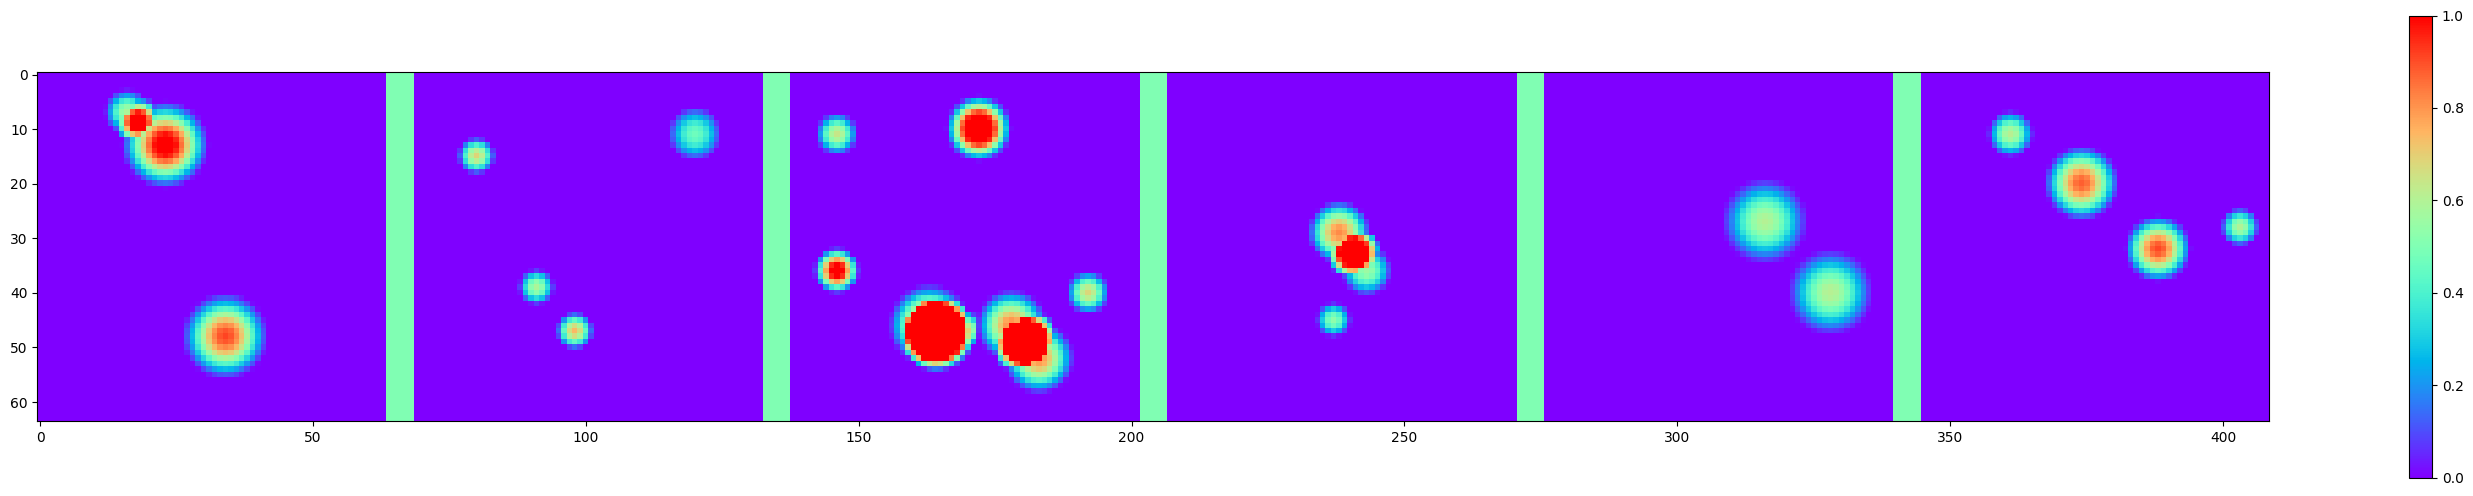

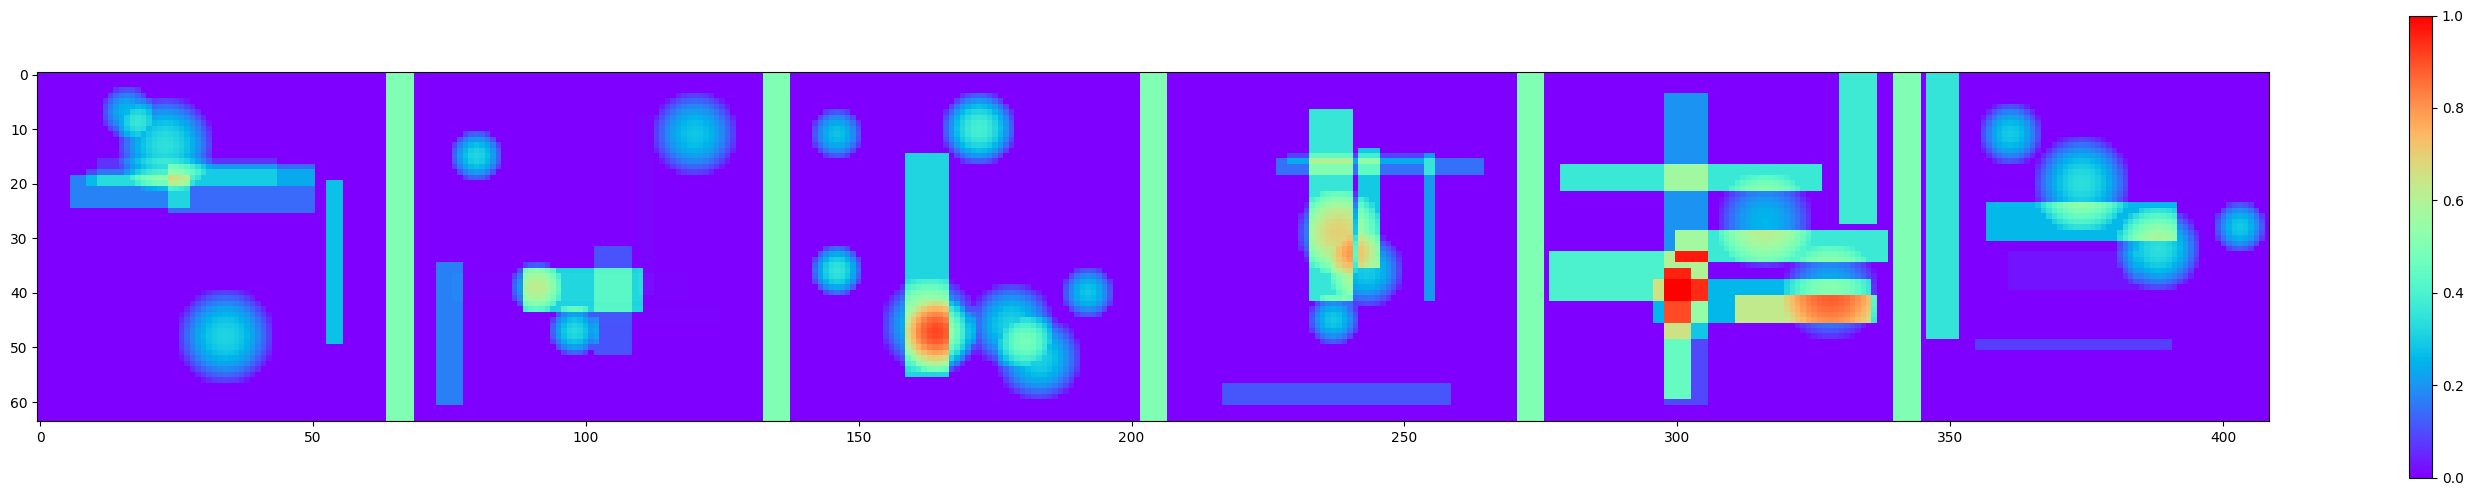

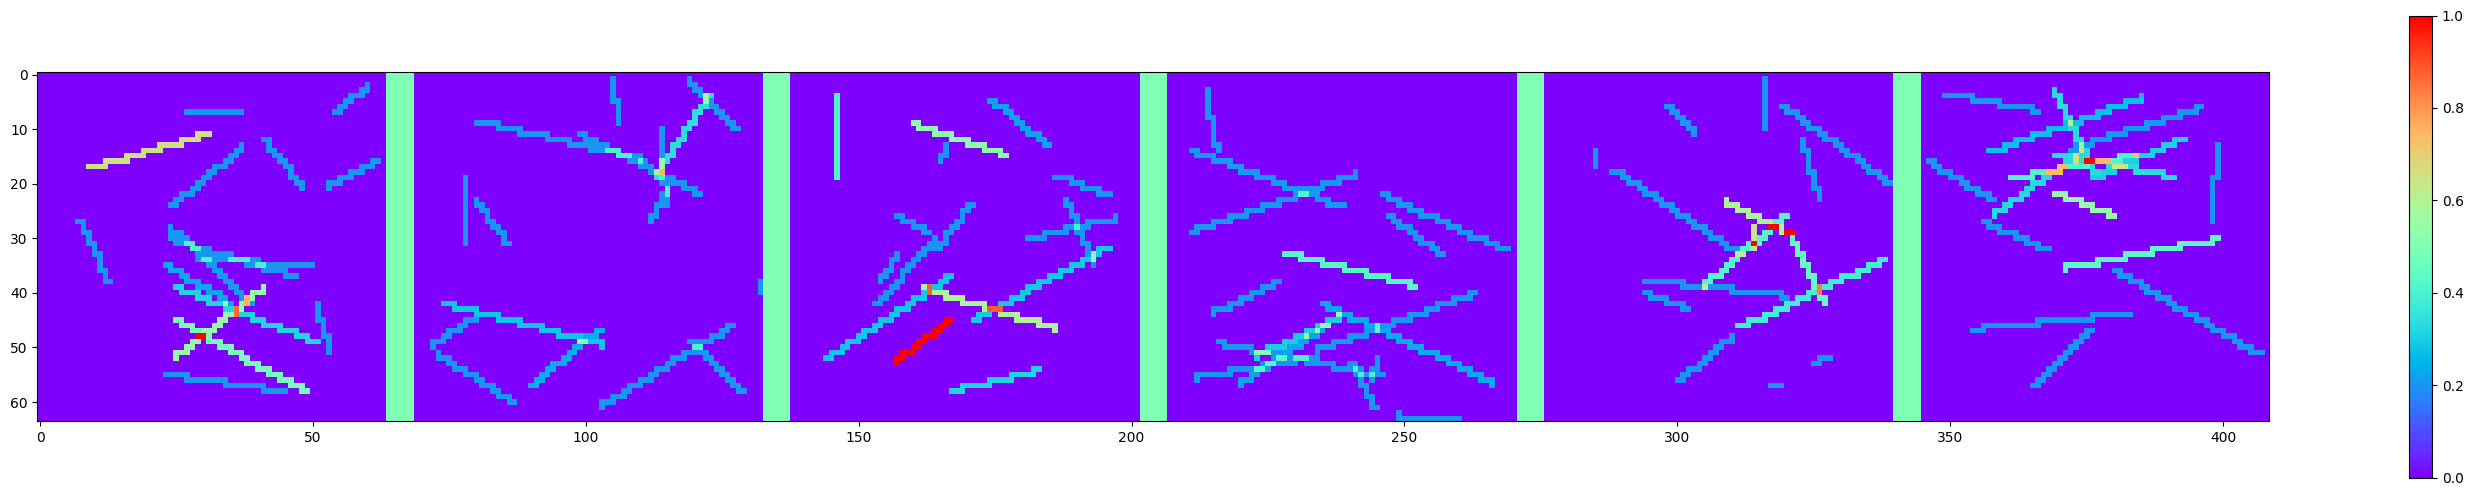

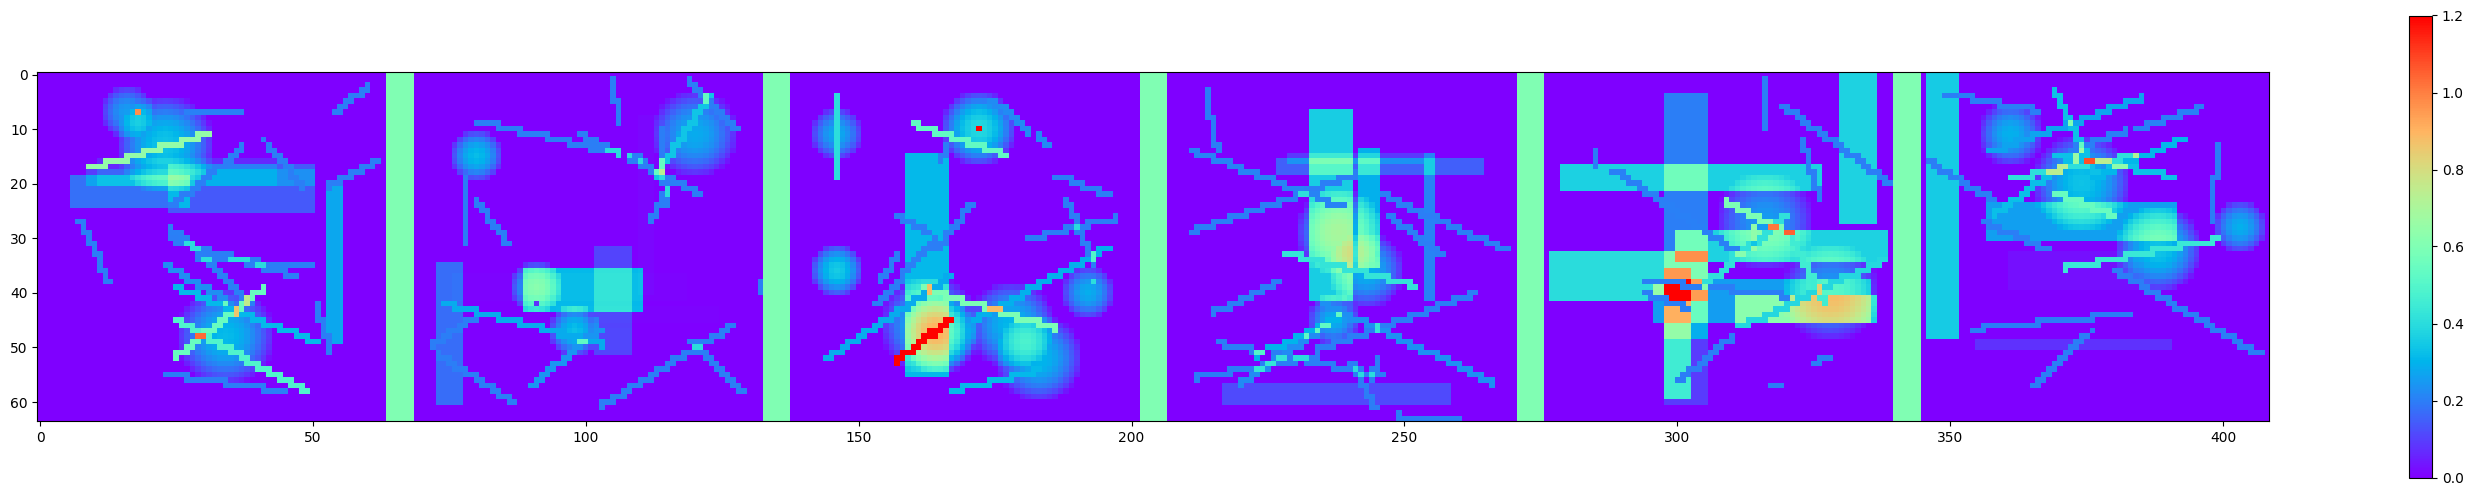

In [4]:
from PREAC.utile_Transformers import voir_batch2D, gen_image_with_pairs, set_tensor_values

# Notre jeu de données contient:
# une cible parfaite (lamedeau)
# des triplets "pluviometres" :
# (lon_pluvio, lat_pluvio, taux de pluie mesuré)
# des quintuplets "cmls" associés aux antennes A & B:
# (lon_A, lat_A, lat_B, lon_B, taux de pluie moyen entre A et B)

batch_size = 6
n_pairs = 16
n_points = 16
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)

# lame d'eau "idéale"
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(lamedeau, 6, fig1, k=0, min_scale=0, max_scale=1)

# images radar (bruitées)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(radar, 6, fig2, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(cmls_spatialises, 6, fig3, k=0, min_scale=0, max_scale=1)

# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig4 = plt.figure(4, figsize=(36, 6))
cmls_spatialises = set_tensor_values(cmls_spatialises, pluviometres, 64)
radar[cmls_spatialises > 0] = cmls_spatialises[cmls_spatialises > 0 ]
voir_batch2D(radar, 6, fig4, k=0, min_scale=0., max_scale=1.2)


**Questions intéressantes** : \\
Pourquoi est-ce que le temps de génération des images est long la première fois qu'on lance le code, mais pas les suivantes ? \\
En quoi les cmls et les pluviomètres peuvent-ils aider à atteindre la cible (c'est à dire la lame d'eau complète) ? \\

## B. Traitement par FCN

A partir des ateliers précédents, il est possible de définir
une approche simple permettant de combiner les trois sources d'information.
Seule obstacle : comment concaténer les entrées. D'où le code suivant:

In [ ]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)

In [17]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
pluviometres_spatialises =  -0.1 * torch.ones(radar.shape)
pluviometres_spatialises = set_tensor_values(pluviometres_spatialises, pluviometres, 64)
input = torch.cat([radar, pluviometres_spatialises, cmls_spatialises], dim = 1)
print(input.shape)

torch.Size([6, 3, 64, 64])


**Questions intéressantes** : \\
Pourquoi est-ce qu'on créé une matrice de -0.1 pour les pluviomètres spatialisés ? \\
Comment instancier un UNet pour prendre ce type d'input en entrée ? \\
Visualiser les sorties au bout de cinquante époques (100 batches de 32 par époque).

## C. Encodage des différentes variables qui vont alimenter le transformer

In [5]:
# Paramètres du modèle :
image_size = [64,64]
channels = 1
patch_size = 4
d_model = 120
mlp_expansion_ratio = 4
d_ff = mlp_expansion_ratio * d_model
n_heads = 4
n_layers = 12

In [6]:
# Module interne du réseau responsable de l'encodage des variables :
from PREAC.utile_Transformers import UnifiedEmbedding
ue = UnifiedEmbedding(d_model, patch_size, channels)


In [16]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
embeddings = ue(radar, pluviometres, cmls)
print(embeddings.shape)

torch.Size([6, 288, 120])


**Question intéressante** : \\
Comment interpréter les dimensions de l'input après encodage ? \\


## D. Entraînement du Transformer

In [30]:
from PREAC.utile_Transformers import FusionTransformer
model = FusionTransformer(image_size, patch_size, n_layers, d_model, d_ff, n_heads, channels=1)
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
model(radar, pluviometres, cmls).shape

torch.Size([6, 1, 64, 64])

In [31]:
device = torch.device('cuda:0')
model = model.to(device)

In [32]:
def criterion(output, target):
  mask = (target > 0).detach()
  return torch.abs((output - target)).mean() + torch.abs((output - target))[mask].mean()

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), 10**(-4))

In [33]:
nepochs = 300
nbatches = 100
batchsize = 32

train_losses = []  # List to store training losses

for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")

    epoch_losses = []  # List to store losses for each batch in the epoch

    for i in range(nbatches):
        # Load inputs
        # lamedeau, pluviometres, radar, cmls_spatialises, cmls
        full_target, partial_target, noisy_images, y, pairs_list = gen_image_with_pairs(batchsize, n_pairs, n_points)

        noisy_images = noisy_images.to(device)
        pairs_list = pairs_list.to(device)
        partial_target = partial_target.to(device)
        full_target = y.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(noisy_images, partial_target, pairs_list)  # Forward pass
        loss = criterion(outputs, full_target)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        epoch_losses.append(loss.detach().cpu().item())  # Append the loss

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')


Epoch 1/300
Epoch loss: 0.3935
Epoch 2/300
Epoch loss: 0.2773
Epoch 3/300
Epoch loss: 0.2527
Epoch 4/300
Epoch loss: 0.2452
Epoch 5/300
Epoch loss: 0.2381
Epoch 6/300
Epoch loss: 0.2388
Epoch 7/300
Epoch loss: 0.2379
Epoch 8/300
Epoch loss: 0.2360
Epoch 9/300
Epoch loss: 0.2340
Epoch 10/300
Epoch loss: 0.2309
Epoch 11/300
Epoch loss: 0.2332
Epoch 12/300
Epoch loss: 0.2336
Epoch 13/300
Epoch loss: 0.2332
Epoch 14/300
Epoch loss: 0.2314
Epoch 15/300
Epoch loss: 0.2322
Epoch 16/300
Epoch loss: 0.2307
Epoch 17/300
Epoch loss: 0.2309
Epoch 18/300
Epoch loss: 0.2307
Epoch 19/300
Epoch loss: 0.2303
Epoch 20/300
Epoch loss: 0.2306
Epoch 21/300
Epoch loss: 0.2299
Epoch 22/300
Epoch loss: 0.2311
Epoch 23/300
Epoch loss: 0.2319
Epoch 24/300
Epoch loss: 0.2334
Epoch 25/300
Epoch loss: 0.2287
Epoch 26/300
Epoch loss: 0.2293
Epoch 27/300
Epoch loss: 0.2294
Epoch 28/300
Epoch loss: 0.2302
Epoch 29/300
Epoch loss: 0.2292
Epoch 30/300
Epoch loss: 0.2309
Epoch 31/300
Epoch loss: 0.2315
Epoch 32/300
Epoc

KeyboardInterrupt: 

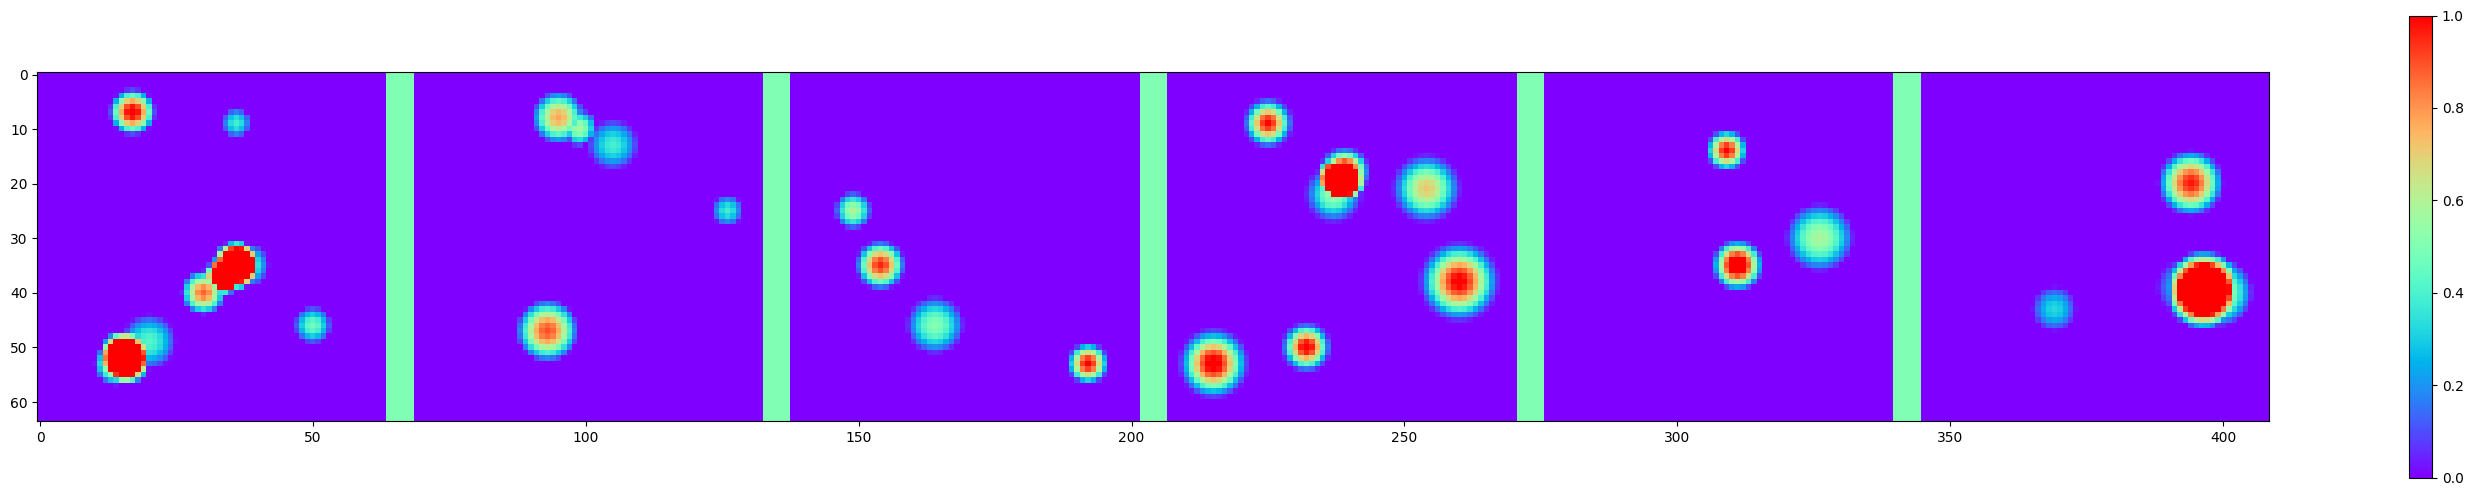

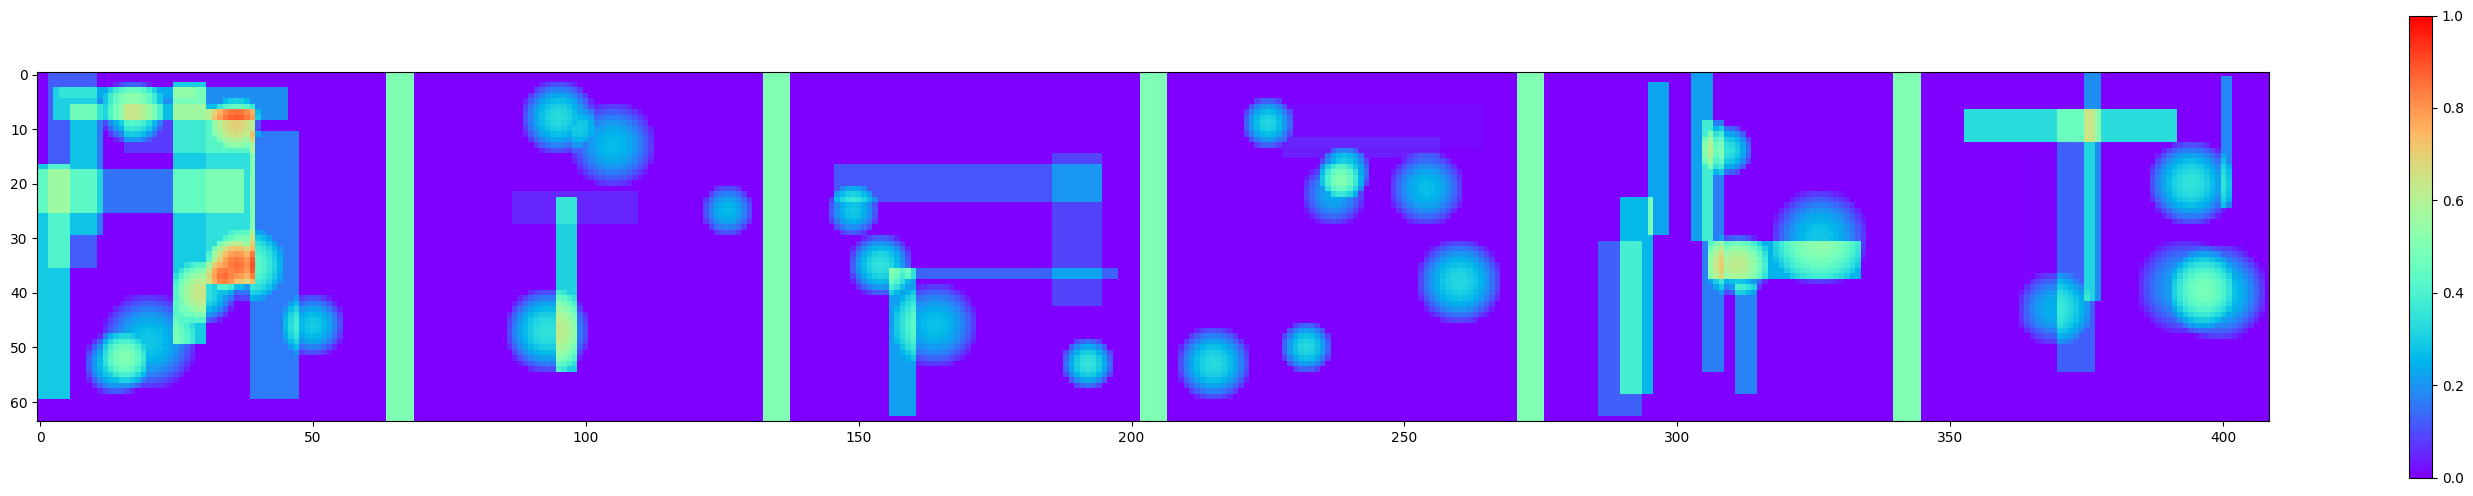

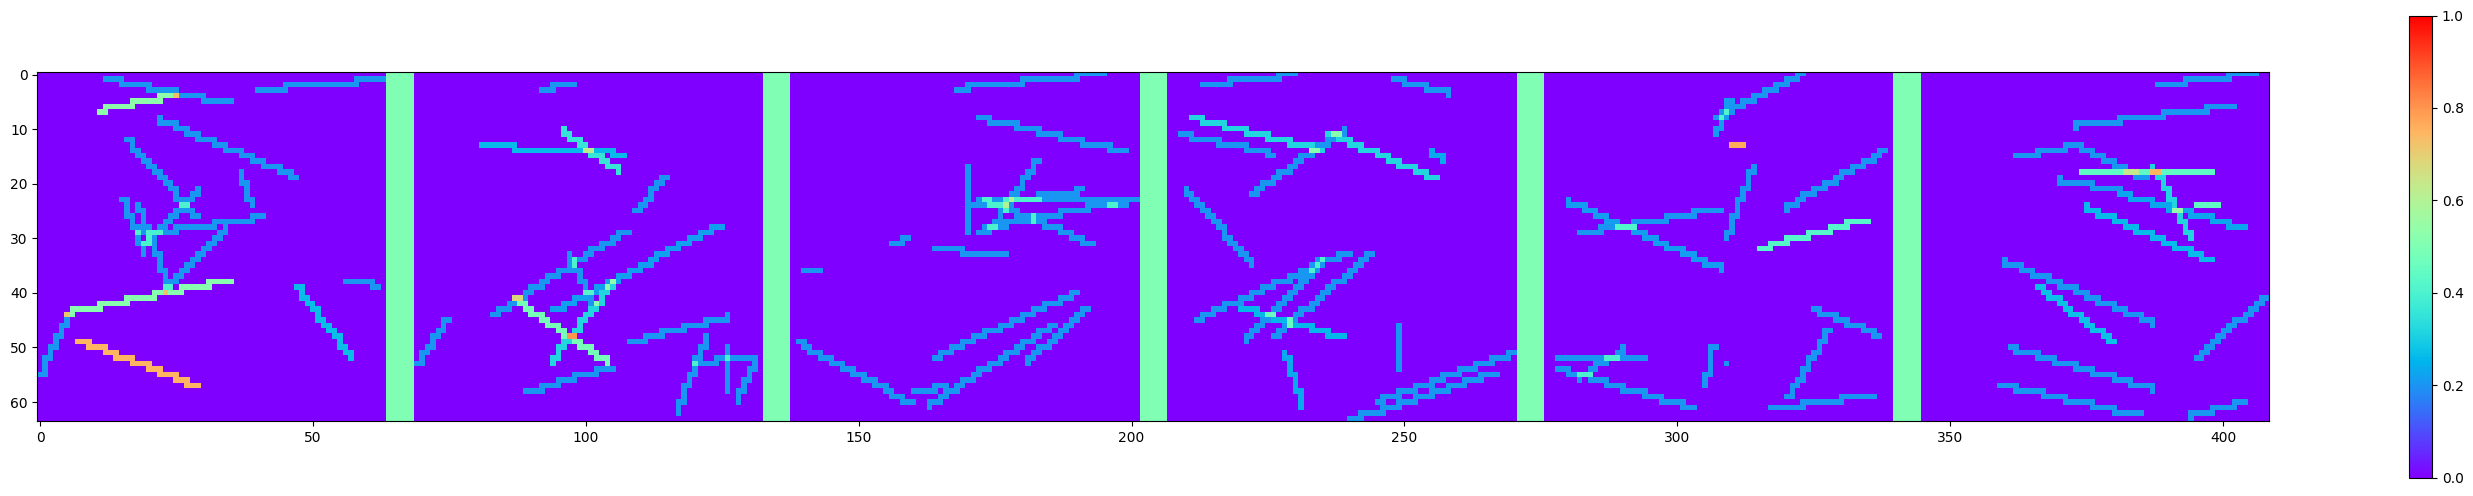

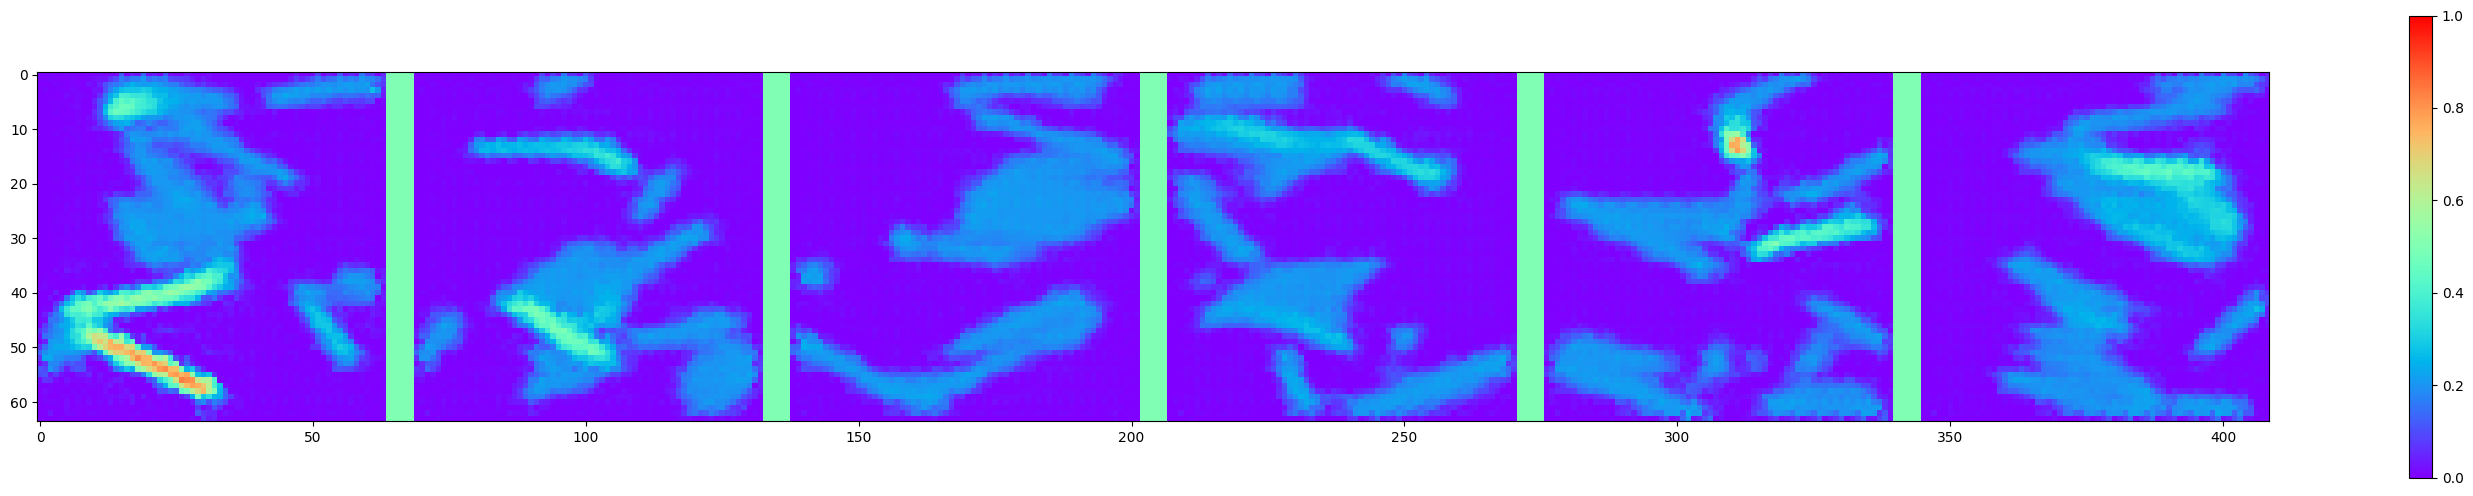

In [34]:
#visualization:

model.eval()

full_target, partial_target, noisy_images, traces, pairs_list = gen_image_with_pairs(6, n_pairs, n_points)
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)


radar = radar.to(device)
cmls = cmls.to(device)
pluviometres = pluviometres.to(device)

outputs = model(radar, pluviometres, cmls)

radar = radar.cpu()
cmls = cmls.cpu()
pluviometres = pluviometres.cpu()
outputs = outputs.cpu().detach()

# lame d'eau "idéale"
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(lamedeau, 6, fig1, k=0, min_scale=0, max_scale=1)

# images radar (bruitées)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(radar, 6, fig2, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(cmls_spatialises, 6, fig3, k=0, min_scale=0, max_scale=1)

# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(outputs, 6, fig3, k=0, min_scale=0, max_scale=1)



**Questions intéressantes** : \\
Quelle différence qualitative entre les outputs ? \\
Que doit faire le transformer "en plus", comparé au FCN ?



## E. Chargement d'un Transformer entraîné

In [ ]:
# Avec France Transfert ??
# !curl 'https://francetransfert.numerique.gouv.fr/api-private/download-module/generate-download-url' -X POST \
# -H 'Content-Type: application/json' \
# -H 'Origin:https://francetransfert.numerique.gouv.fr' \
# --data-raw '{"enclosure":"164ea132-cf5e-4a8d-a084-62841b3122ec","recipient":"cGllcnJlLmxlcGV0aXRAbWV0ZW8uZnI%3D","token":"ddf68980-7b19-4eef-8a34-88a3e32a0f71","senderToken":null,"password":"2q*vbl62!FK@Z"}'

In [24]:
# Modèles entraînés sur 900 époques :
# mViT_900ep.pth comme au D.
# mViT_0radar_900ep.pth avec, au préalable: radar = 0 x radar
! wget https://www.grosfichiers.com/3znfBP3fXGV_hrS657zSEDp
! unzip 3znfBP3fXGV_hrS657zSEDp
! rm 3znfBP3fXGV_hrS657zSEDp

--2024-05-07 14:20:55--  https://www.grosfichiers.com/3znfBP3fXGV_hrS657zSEDp
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26298074 (25M) [application/octet-stream]
Saving to: ‘3znfBP3fXGV_hrS657zSEDp’

3znfBP3fXGV_hrS657z 100%[===================>]  25.08M  7.37MB/s    in 3.4s    

2024-05-07 14:20:59 (7.37 MB/s) - ‘3znfBP3fXGV_hrS657zSEDp’ saved [26298074/26298074]

Archive:  3znfBP3fXGV_hrS657zSEDp
 extracting: mViT_0radar_900ep/data.pkl  
 extracting: mViT_0radar_900ep/byteorder  
 extracting: mViT_0radar_900ep/data/0  
 extracting: mViT_0radar_900ep/data/1  
 extracting: mViT_0radar_900ep/data/10  
 extracting: mViT_0radar_900ep/data/100  
 extracting: mViT_0radar_900ep/data/101  
 extracting: mViT_0radar_900ep/data/102  
 extracting: mViT_0radar_900ep/data/103  
 extracting: mViT_0radar_900ep/data/104  
 extrac

In [25]:
! ! rm 3znfBP3fXGV_hrS657zSEDp
! ls

K3aaxZcSnX4_Fic8rPjJ9yZ  K3aaxZcSnX4_Fic8rPjJ9yZ.1  mViT_0radar_900ep  PREAC  sample_data


In [28]:
! ls mViT_0radar_900ep

byteorder  data  data.pkl  version


In [27]:
# charger un checkpoint avec torch .load
# visualiser les outputs

checkpoint = torch.load('mViT_0radar_900ep')
model.load_state_dict(checkpoint['model_state_dict'])

IsADirectoryError: [Errno 21] Is a directory: 'mViT_0radar_900ep'

**Question intéressante** : \\
Le transformer parvient-il à exploiter les valeurs de pluviomètres et des cmls  ?

Bibliographie :  [Jaegle et al. 2020](https://arxiv.org/abs/1811.12739)